In [1]:
import pandas as pd
import numpy as np
from pybaseball import statcast
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from unidecode import unidecode


In [ ]:
"""
data20_22 = statcast(start_dt = "2020-04-01", end_dt = "2022-12-01") 
data20_22.to_csv('Statcast_2020_to_2022.csv')
data23 = statcast(start_dt = "2023-04-01", end_dt = "2023-12-01")
data23.to_csv('Statcast_2023.csv')
"""

In [2]:
#Read in data
data20_22 = pd.read_csv("Statcast_2020_to_2022.csv")
data23 = pd.read_csv("Statcast_2023.csv")

In [3]:
data20_22['player_name'] = data20_22['player_name'].apply(unidecode)
data23['player_name'] = data23['player_name'].apply(unidecode)

#Select columns
data20_22 = data20_22[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','stand','p_throws','delta_run_exp','balls','strikes']]
data23 = data23[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','stand','p_throws','delta_run_exp','balls','strikes']]

data20_22['p_throws'] = data20_22['p_throws'].map({'L': 0, 'R': 1})
data23['p_throws'] = data23['p_throws'].map({'L': 0, 'R': 1})

data20_22['stand'] = data20_22['stand'].map({'L': 0, 'R': 1})
data23['stand'] = data23['stand'].map({'L': 0, 'R': 1})

#Flip to get view from pitcher
data20_22['pfx_x'] = data20_22['pfx_x'] * -1
data23['pfx_x'] = data23['pfx_x'] * -1

#Change to inches
data20_22['pfx_x'] = data20_22['pfx_x'] * 12
data20_22['pfx_z'] = data20_22['pfx_z'] * 12
data23['pfx_x'] = data23['pfx_x'] * 12
data23['pfx_z'] = data23['pfx_z'] * 12

#Drop na values
data20_22 = data20_22.dropna()
data23 = data23.dropna()

#Remove unnecessary pitches
data20_22 = data20_22[data20_22.pitch_type != 'PO']
data23 = data23[data23.pitch_type != 'PO']

#Retag pitches
data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FF','FA'], 'Fastball')
data23['pitch_type'] = data23['pitch_type'].replace(['FF','FA'], 'Fastball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SI'], 'Sinker')
data23['pitch_type'] = data23['pitch_type'].replace(['SI'], 'Sinker')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FC'], 'Cutter')
data23['pitch_type'] = data23['pitch_type'].replace(['FC'], 'Cutter')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SL'], 'Slider')
data23['pitch_type'] = data23['pitch_type'].replace(['SL'], 'Slider')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['ST'], 'Sweeper')
data23['pitch_type'] = data23['pitch_type'].replace(['ST'], 'Sweeper')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')
data23['pitch_type'] = data23['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')
data23['pitch_type'] = data23['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FS'], 'Splitter')
data23['pitch_type'] = data23['pitch_type'].replace(['FS'], 'Splitter')

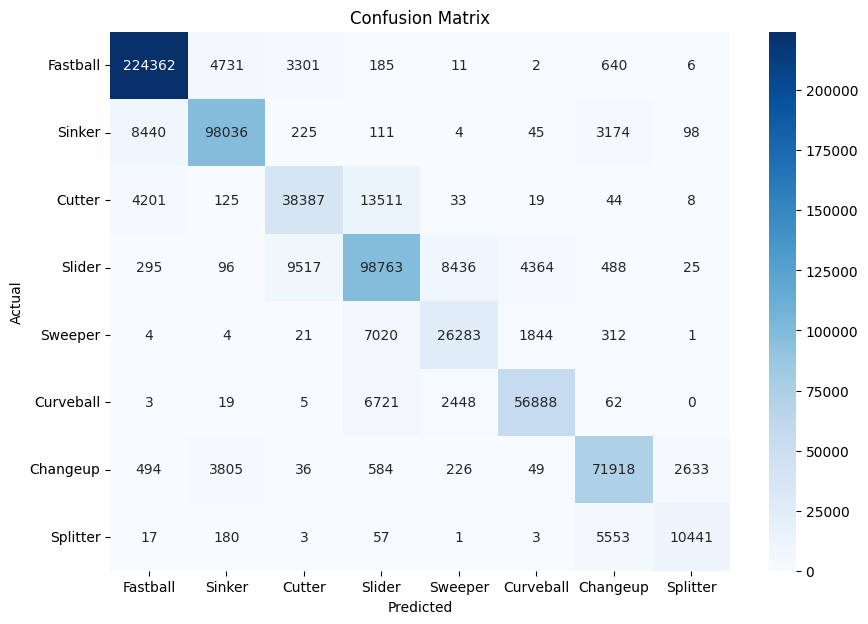

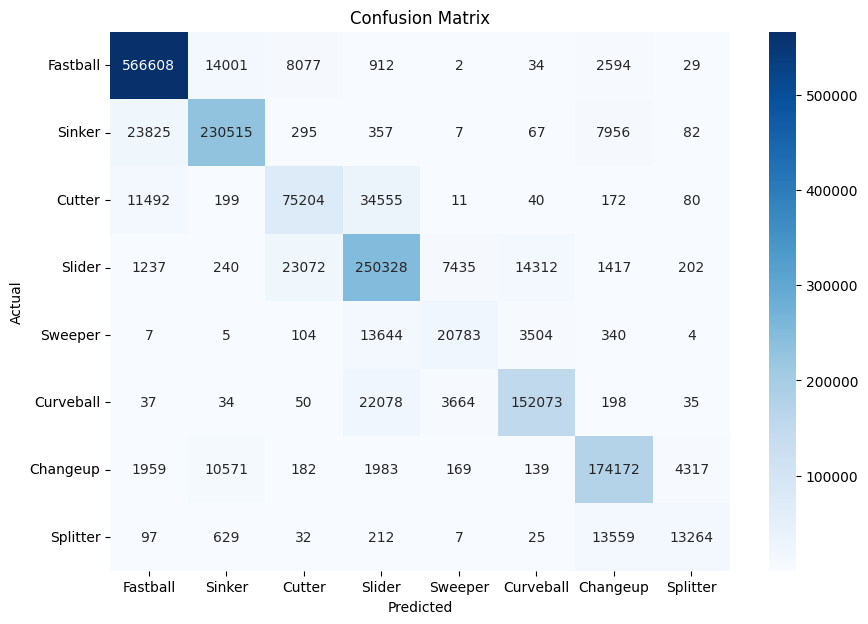

In [4]:
#caculate vaa and haa
def approach_angles(df):
    yf = 17/12
    y0 = 50
    df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * y0 - yf))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
    df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])

    df['vaa'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['haa'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    return df

#caculate estimated axis differential and estimated spin efficiency
def axis_differential(df):
    df['spin_axis'] = (df['spin_axis']+ 180) % 360
    df['calc_spin'] = np.arctan2(df['pfx_z'],df['pfx_x']) * (180 / np.pi)
    df['axis_dif'] = np.minimum(
        np.abs(df['spin_axis'] - df['calc_spin']),
        360 - np.abs(df['spin_axis'] - df['calc_spin'])
    )
    return df

def find_most_common_fastball(df):
    fastball_types = df[df['pitch_type'].isin(['Fastball', 'Sinker', 'Cutter'])]
    most_common_fastball = fastball_types.groupby(['player_name', 'pitch_type']).size().reset_index(name='count')
    most_common_fastball = most_common_fastball.loc[most_common_fastball.groupby('player_name')['count'].idxmax()]
    most_common_fastball = most_common_fastball[['player_name', 'pitch_type']]
    most_common_fastball.rename(columns={'pitch_type': 'most_common_fastball'}, inplace=True)
    return most_common_fastball

def add_velocity_and_movement_diff(df):
    most_common_fastball = find_most_common_fastball(df)
    
    df = df.merge(most_common_fastball, on='player_name', how='left')
    
    avg_stats = df[df['pitch_type'] == df['most_common_fastball']].groupby('player_name')[['release_speed', 'pfx_x', 'pfx_z']].mean().reset_index()
    avg_stats.rename(columns={
        'release_speed': 'avg_fastball_velocity',
        'pfx_x': 'avg_fastball_pfx_x',
        'pfx_z': 'avg_fastball_pfx_z'
    }, inplace=True)
    
    df = df.merge(avg_stats, on='player_name', how='left')
    
    df['velocity_diff'] = df['avg_fastball_velocity'] - df['release_speed']
    df['horizontal_movement_diff'] = df['avg_fastball_pfx_x'] - df['pfx_x']
    df['vertical_movement_diff'] = df['avg_fastball_pfx_z'] - df['pfx_z']
    
    return df

def reclassify_pitches(df):
    
    filtered_data = df

    def convert_labels(df):
        numbers = {"Fastball": 0, "Sinker": 1, "Cutter": 2, "Slider": 3, "Sweeper": 4, "Curveball": 5, "Changeup": 6, "Splitter": 7}
        df['pitch_type_num'] = df['pitch_type'].map(numbers)
        return df

    filtered_data = convert_labels(filtered_data)

    X = filtered_data[['pfx_x', 'pfx_z', 'release_speed', 'release_spin_rate', 'spin_axis']]
    y = filtered_data['pitch_type_num']

    forest = XGBClassifier(random_state=42)
    forest.fit(X, y)

    predictions = forest.predict(X)

    cm = confusion_matrix(filtered_data['pitch_type_num'], predictions)
    cm_df = pd.DataFrame(cm, index=["Fastball", "Sinker", "Cutter", "Slider", "Sweeper", "Curveball", "Changeup", "Splitter"],
                         columns=["Fastball", "Sinker", "Cutter", "Slider", "Sweeper", "Curveball", "Changeup", "Splitter"])

    #Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    predictions_series = pd.Series(predictions, index=filtered_data.index)
    numbers_to_names = {0: "Fastball", 1: "Sinker", 2: "Cutter", 3: "Slider", 4: "Sweeper", 5: "Curveball", 6: "Changeup", 7: "Splitter"}
    filtered_data['predicted_pitch_type'] = predictions_series.map(numbers_to_names)
    filtered_data = filtered_data['predicted_pitch_type']

    return filtered_data

data20_22 = approach_angles(data20_22)
data23 = approach_angles(data23)

data20_22 = axis_differential(data20_22)
data23 = axis_differential(data23)

data20_22 = add_velocity_and_movement_diff(data20_22)
data23 = add_velocity_and_movement_diff(data23)

data23['pred_pitch_type'] = reclassify_pitches(data23)
data20_22['pred_pitch_type'] = reclassify_pitches(data20_22)


In [5]:
# Combining Fastball, Sinker, and Cutter into one dataframe
fastball_20_22 = data20_22[data20_22.pitch_type.isin(['Fastball', 'Sinker', 'Cutter'])]
fastball_23 = data23[data23.pitch_type.isin(['Fastball', 'Sinker', 'Cutter'])]

# Combining Slider and Sweeper into one dataframe
breakingball_20_22 = data20_22[data20_22.pitch_type.isin(['Slider', 'Sweeper', 'Curveball'])]
breakingball_23 = data23[data23.pitch_type.isin(['Slider', 'Sweeper', 'Curveball'])]

# Combining Changeup and Splitter into one dataframe
offspeed_20_22 = data20_22[data20_22.pitch_type.isin(['Changeup', 'Splitter'])]
offspeed_23 = data23[data23.pitch_type.isin(['Changeup', 'Splitter'])]

In [6]:
features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z', 'axis_dif', 'velocity_diff', 'horizontal_movement_diff', 'vertical_movement_diff','game_year']
fball_features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z', 'axis_dif','game_year']

#Split into train and test

fastball_x = fastball_20_22[fball_features]
fastball_y = fastball_20_22['delta_run_exp']

x_train_fastball, x_test_fastball, y_train_fastball, y_test_fastball = train_test_split(fastball_x, fastball_y, train_size = 0.75, random_state = 12345)

breakingball_x = breakingball_20_22[features]
breakingball_y = breakingball_20_22['delta_run_exp']

x_train_breakingball, x_test_breakingball, y_train_breakingball, y_test_breakingball = train_test_split(breakingball_x, breakingball_y, train_size=0.75, random_state=12345)

offspeed_x = offspeed_20_22[features]
offspeed_y = offspeed_20_22['delta_run_exp']

x_train_offspeed, x_test_offspeed, y_train_offspeed, y_test_offspeed = train_test_split(offspeed_x, offspeed_y, train_size=0.75, random_state=12345)


In [7]:
#Set params for catboost models (Random ones right now)
params = {
    'iterations': 500,
    'depth': 5,
    'learning_rate': 0.11, #manual checks with FIP corr both predictive and descriptive
    'random_seed': 12345
    
}

#Train each model

#Fastball
fastball_model = CatBoostRegressor(**params)
fastball_model.fit(x_train_fastball, y_train_fastball)

#Sinker
breakingball_model = CatBoostRegressor(**params)
breakingball_model.fit(x_train_breakingball, y_train_breakingball)

#Cutter
offspeed_model = CatBoostRegressor(**params)
offspeed_model.fit(x_train_offspeed, y_train_offspeed)

0:	learn: 0.2452046	total: 81.1ms	remaining: 40.5s
1:	learn: 0.2451997	total: 105ms	remaining: 26.3s
2:	learn: 0.2451914	total: 124ms	remaining: 20.6s
3:	learn: 0.2451838	total: 142ms	remaining: 17.7s
4:	learn: 0.2451772	total: 163ms	remaining: 16.1s
5:	learn: 0.2451724	total: 182ms	remaining: 15s
6:	learn: 0.2451671	total: 203ms	remaining: 14.3s
7:	learn: 0.2451620	total: 225ms	remaining: 13.8s
8:	learn: 0.2451589	total: 245ms	remaining: 13.4s
9:	learn: 0.2451555	total: 265ms	remaining: 13s
10:	learn: 0.2451515	total: 285ms	remaining: 12.7s
11:	learn: 0.2451480	total: 303ms	remaining: 12.3s
12:	learn: 0.2451447	total: 323ms	remaining: 12.1s
13:	learn: 0.2451416	total: 347ms	remaining: 12s
14:	learn: 0.2451385	total: 367ms	remaining: 11.9s
15:	learn: 0.2451354	total: 389ms	remaining: 11.8s
16:	learn: 0.2451322	total: 414ms	remaining: 11.8s
17:	learn: 0.2451290	total: 436ms	remaining: 11.7s
18:	learn: 0.2451261	total: 460ms	remaining: 11.6s
19:	learn: 0.2451242	total: 487ms	remaining: 1

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

# Evaluate each model
models = {
    'Fastball': (fastball_model, x_test_fastball, y_test_fastball),
    'Breakingball': (breakingball_model, x_test_breakingball, y_test_breakingball),
    'Offspeed': (offspeed_model, x_test_offspeed, y_test_offspeed),
}

for pitch_type, (model, X_test, y_test) in models.items():
    metrics = evaluate_model(model, X_test, y_test)
    print(f"\nEvaluation metrics for {pitch_type}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Optional: Calculate overall average metrics
overall_metrics = {metric: 0 for metric in ['MSE', 'RMSE', 'MAE']}
for pitch_type, (model, X_test, y_test) in models.items():
    metrics = evaluate_model(model, X_test, y_test)
    for metric, value in metrics.items():
        overall_metrics[metric] += value

for metric, total in overall_metrics.items():
    overall_metrics[metric] = total / len(models)

print("\nOverall average metrics:")
for metric, value in overall_metrics.items():
    print(f"Average {metric}: {value:.4f}")


Evaluation metrics for Fastball:
MSE: 0.0598
RMSE: 0.2445
MAE: 0.1244

Evaluation metrics for Breakingball:
MSE: 0.0560
RMSE: 0.2367
MAE: 0.1166

Evaluation metrics for Offspeed:
MSE: 0.0630
RMSE: 0.2510
MAE: 0.1291

Overall average metrics:
Average MSE: 0.0596
Average RMSE: 0.2441
Average MAE: 0.1234


In [10]:
#Predictions
fastball_23['pred'] = fastball_model.predict(fastball_23[fball_features])

breakingball_23['pred'] = breakingball_model.predict(breakingball_23[features])

offspeed_23['pred'] = offspeed_model.predict(offspeed_23[features])

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_36090/3149739183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_23['pred'] = fastball_model.predict(fastball_23[fball_features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_36090/3149739183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakingball_23['pred'] = breakingball_model.predict(breakingball_23[features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_36090/3149739183.py:6: SettingWithCopyWarni

In [11]:
combined_df = pd.concat([fastball_23, breakingball_23, offspeed_23])

def scale_and_score(df):
    df['scaled'] = df['pred'] - df['pred'].max()
    df['scaled'] = abs(df['scaled'])
    df['scaled'] = df['scaled'] - df['scaled'].mean()
    df['scaled'] = df['scaled'] / df['scaled'].std()
    df['score'] = df['scaled'] * 10 + 100
    return df

scale_and_score(combined_df)

fastball_23 = combined_df[combined_df.pitch_type == 'Fastball']
sinker_23 = combined_df[combined_df.pitch_type == 'Sinker']
cutter_23 = combined_df[combined_df.pitch_type == 'Cutter']
slider_23 = combined_df[combined_df.pitch_type == 'Slider']
sweeper_23 = combined_df[combined_df.pitch_type == 'Sweeper']
curveball_23 = combined_df[combined_df.pitch_type == 'Curveball']
changeup_23 = combined_df[combined_df.pitch_type == 'Changeup']
splitter_23 = combined_df[combined_df.pitch_type == 'Splitter']


def calculate_mean_scores(df):
    mean_scores = df.groupby('player_name')['score'].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

mean_scores_fastball = calculate_mean_scores(fastball_23)
mean_scores_sinker = calculate_mean_scores(sinker_23)
mean_scores_cutter = calculate_mean_scores(cutter_23)
mean_scores_slider = calculate_mean_scores(slider_23)
mean_scores_sweeper = calculate_mean_scores(sweeper_23)
mean_scores_curveball = calculate_mean_scores(curveball_23)
mean_scores_changeup = calculate_mean_scores(changeup_23)
mean_scores_splitter = calculate_mean_scores(splitter_23)


combined_scores = mean_scores_fastball
combined_scores = combined_scores.merge(mean_scores_sinker, how = 'outer', on = 'player_name', suffixes=('','_sinker'))
combined_scores = combined_scores.merge(mean_scores_cutter, how = 'outer', on = 'player_name', suffixes=('','_cutter'))
combined_scores = combined_scores.merge(mean_scores_slider, how = 'outer', on = 'player_name', suffixes=('','_slider'))
combined_scores = combined_scores.merge(mean_scores_sweeper, how = 'outer', on = 'player_name', suffixes=('','_sweeper'))
combined_scores = combined_scores.merge(mean_scores_curveball, how = 'outer', on = 'player_name', suffixes=('','_curveball'))
combined_scores = combined_scores.merge(mean_scores_changeup, how = 'outer', on = 'player_name', suffixes=('','_changeup'))
combined_scores = combined_scores.merge(mean_scores_splitter, how = 'outer', on = 'player_name', suffixes=('','_splitter'))



combined_scores = combined_scores.rename(columns = {
    'mean_scores': 'fastball',
    'mean_scores_sinker': 'sinker',
    'mean_scores_cutter': 'cutter',
    'mean_scores_slider': 'slider',
    'mean_scores_sweeper': 'sweeper',
    'mean_scores_curveball': 'curveball',
    'mean_scores_changeup': 'changeup',
    'mean_scores_splitter': 'splitter'
    }
)

pitch_counts = data23.groupby(['player_name', 'pitch_type']).size().unstack(fill_value=0).reset_index()

combined_data = combined_scores.merge(pitch_counts, how='outer', on='player_name')
combined_data.fillna(0, inplace=True)

combined_data['weighted_fastball'] = combined_data['fastball'] * combined_data['Fastball']
combined_data['weighted_sinker'] = combined_data['sinker'] * combined_data['Sinker']
combined_data['weighted_cutter'] = combined_data['cutter'] * combined_data['Cutter']
combined_data['weighted_slider'] = combined_data['slider'] * combined_data['Slider']
combined_data['weighted_sweeper'] = combined_data['sweeper'] * combined_data['Sweeper']
combined_data['weighted_curveball'] = combined_data['curveball'] * combined_data['Curveball']
combined_data['weighted_changeup'] = combined_data['changeup'] * combined_data['Changeup']
combined_data['weighted_splitter'] = combined_data['splitter'] * combined_data['Splitter']

combined_data['total_weighted_score'] = (
    combined_data['weighted_fastball'] +
    combined_data['weighted_sinker'] +
    combined_data['weighted_cutter'] +
    combined_data['weighted_slider'] +
    combined_data['weighted_sweeper'] +
    combined_data['weighted_curveball'] +
    combined_data['weighted_changeup'] +
    combined_data['weighted_splitter']
)

combined_data['total_pitches'] = (
    combined_data['Fastball'] +
    combined_data['Sinker'] +
    combined_data['Cutter'] +
    combined_data['Slider'] +
    combined_data['Sweeper'] +
    combined_data['Curveball'] +
    combined_data['Changeup'] +
    combined_data['Splitter']
)

combined_data['overall'] = combined_data['total_weighted_score'] / combined_data['total_pitches']
combined_data['overall'] = combined_data['overall'].round(2)

min_pitch_count = 100
combined_data = combined_data[combined_data['total_pitches'] >= min_pitch_count]

combined_data = combined_data[['player_name', 'overall', 'fastball', 'sinker', 'cutter', 'slider', 'sweeper', 'curveball', 'changeup', 'splitter']]
combined_data = combined_data.sort_values(by='overall', ascending=False)

combined_data.to_csv("fun_model.csv", index=False)
combined_data

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
311,"Helsley, Ryan",115.19,115.26,0.00,0.00,117.71,0.00,101.46,0.00,0.0
860,"deGrom, Jacob",114.39,111.11,0.00,0.00,120.52,0.00,106.38,109.10,0.0
387,"Kerkering, Orion",113.47,103.48,106.88,0.00,0.00,117.22,0.00,0.00,0.0
826,"Williams, Devin",113.05,105.27,0.00,106.10,0.00,0.00,0.00,118.82,0.0
139,"Clase, Emmanuel",112.78,99.88,0.00,110.89,116.93,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...
47,"Battenfield, Peyton",80.50,92.47,0.00,60.24,0.00,0.00,99.93,103.39,0.0
517,"Miller, Tyson",80.21,105.97,87.57,0.00,85.40,0.00,-40.84,87.20,0.0
589,"Peralta, Sammy",79.69,84.98,0.00,0.00,91.24,84.92,0.00,69.84,0.0
197,"Doyle, Tommy",68.47,86.43,100.50,47.51,91.46,0.00,0.00,0.00,0.0


In [86]:
def get_top_individual_pitches(pitch_df, pitch_type):
    top_pitches = pitch_df[['player_name', 'pitch_type', 'release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z','score']]
    top_pitches = top_pitches.sort_values(by='score', ascending=False)
    top_pitches['pitch_type'] = pitch_type
    return top_pitches

top_fastball_pitches = get_top_individual_pitches(fastball_23, 'Fastball')
top_sinker_pitches = get_top_individual_pitches(sinker_23, 'Sinker')
top_cutter_pitches = get_top_individual_pitches(cutter_23, 'Cutter')
top_slider_pitches = get_top_individual_pitches(slider_23, 'Slider')
top_sweeper_pitches = get_top_individual_pitches(sweeper_23, 'Sweeper')
top_curveball_pitches = get_top_individual_pitches(curveball_23, 'Curveball')
top_changeup_pitches = get_top_individual_pitches(changeup_23, 'Changeup')
top_splitter_pitches = get_top_individual_pitches(splitter_23, 'Splitter')

top_individual_pitches = pd.concat([
    top_fastball_pitches,
    top_sinker_pitches,
    top_cutter_pitches,
    top_slider_pitches,
    top_sweeper_pitches,
    top_curveball_pitches,
    top_changeup_pitches,
    top_splitter_pitches
])
top_individual_pitches = top_individual_pitches.sort_values(by='score', ascending=True)

top_individual_pitches

,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,release_extension,pfx_x,pfx_z,score
412641,"Rojas, Josh",Fastball,66.0,-3.16,2.66,5.2,9.60,4.20,-485.124249
666309,"Wells, Tyler",Slider,81.1,-1.06,7.04,6.2,-3.48,-1.92,-483.913497
412640,"Rojas, Josh",Fastball,68.7,-3.40,2.88,5.2,12.36,3.72,-455.916911
338205,"Miller, Tyson",Curveball,81.2,-3.63,5.00,7.8,-13.20,-4.68,-400.452036
506315,"Miller, Tyson",Curveball,81.0,-3.89,4.84,7.9,-12.36,-5.28,-389.470809
...,...,...,...,...,...,...,...,...,...
406971,"Hicks, Jordan",Sinker,104.3,-1.67,6.09,6.6,16.08,6.24,267.722349
185707,"Hicks, Jordan",Sinker,103.0,-1.60,6.00,6.7,17.52,8.16,275.931007
616363,"Hicks, Jordan",Sinker,103.1,-1.66,6.12,6.7,14.16,7.92,291.104427
471721,"Hicks, Jordan",Sinker,102.8,-1.70,5.96,6.6,15.36,6.96,303.951068


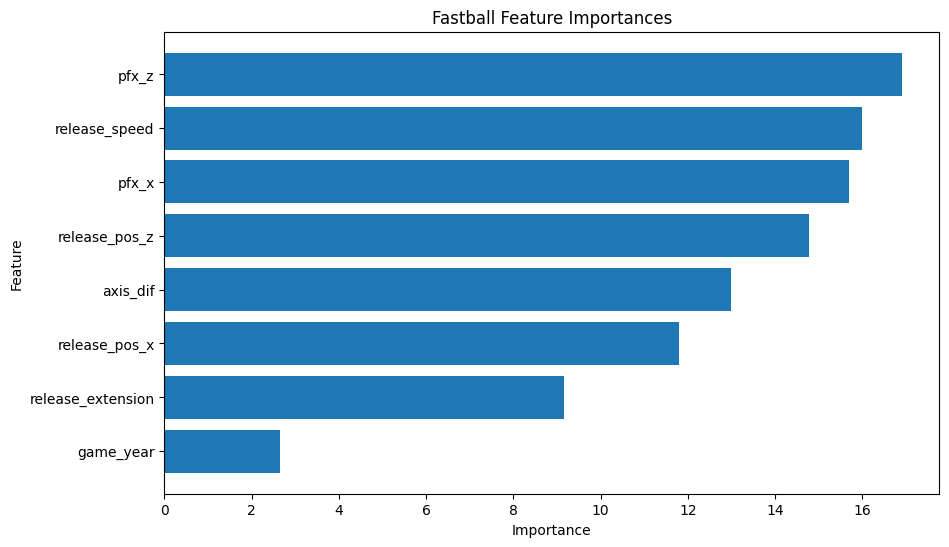

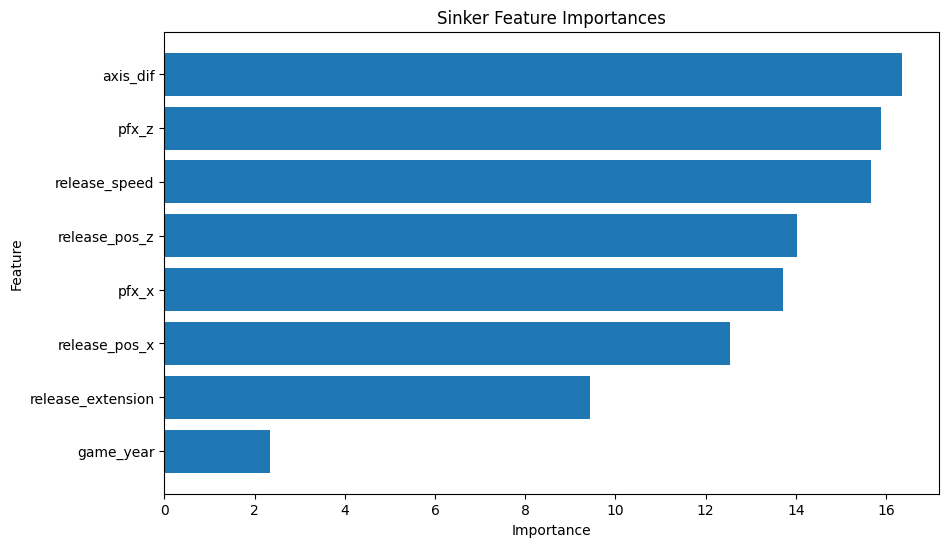

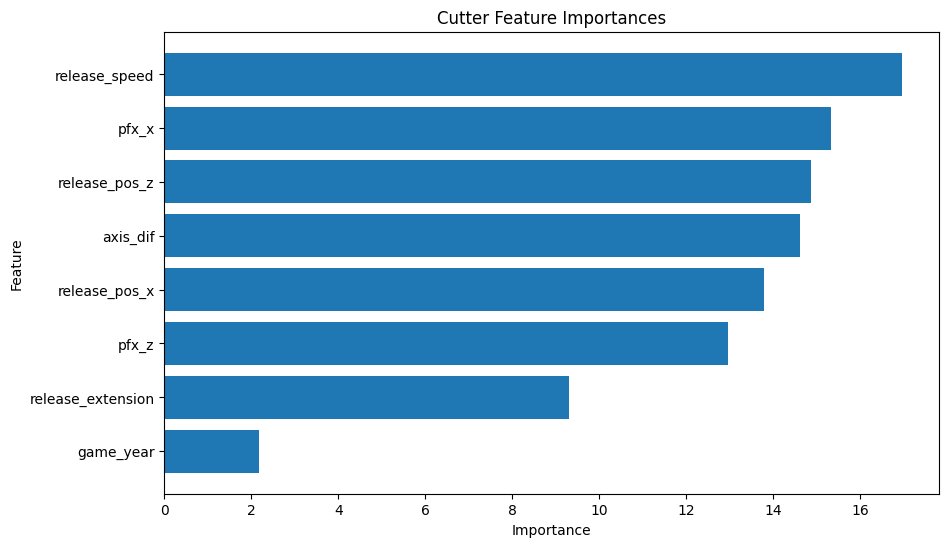

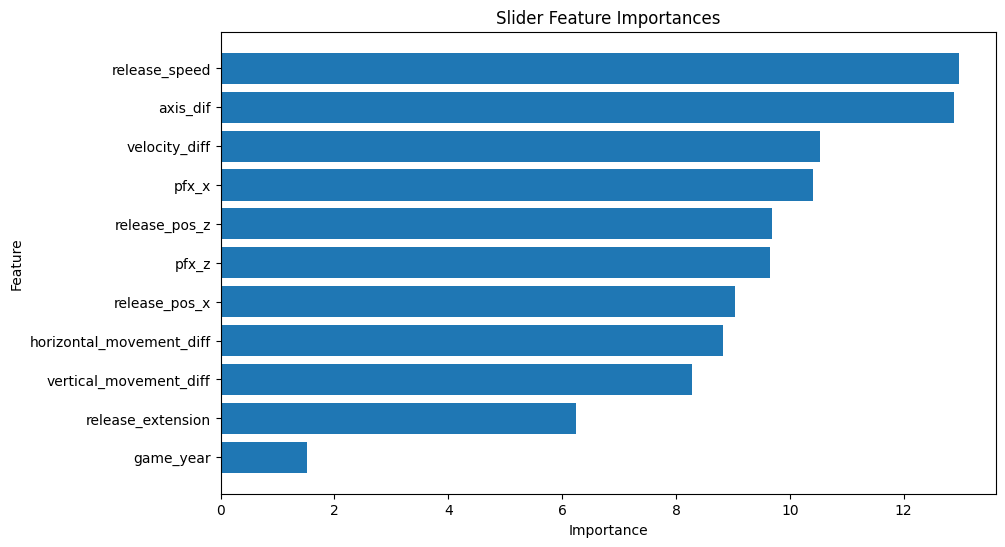

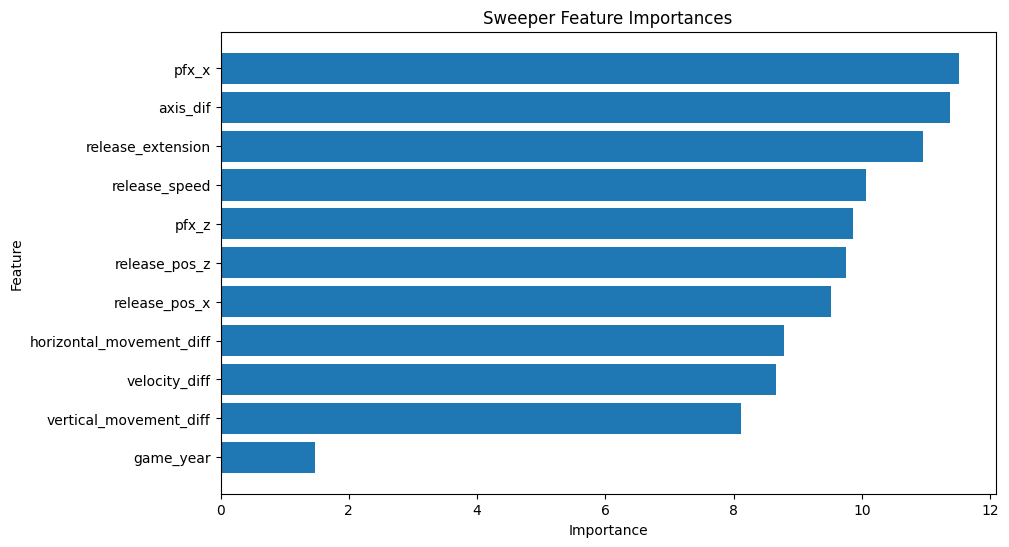

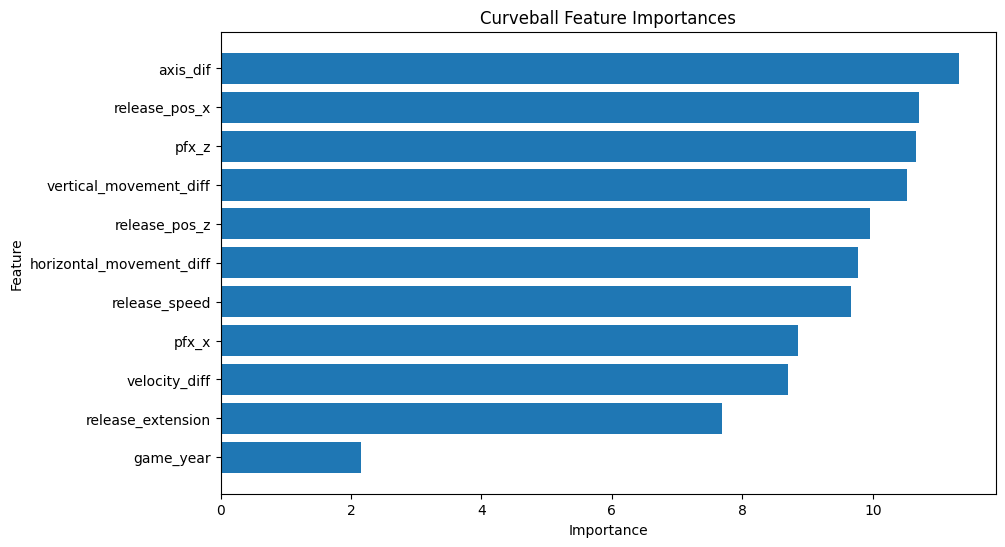

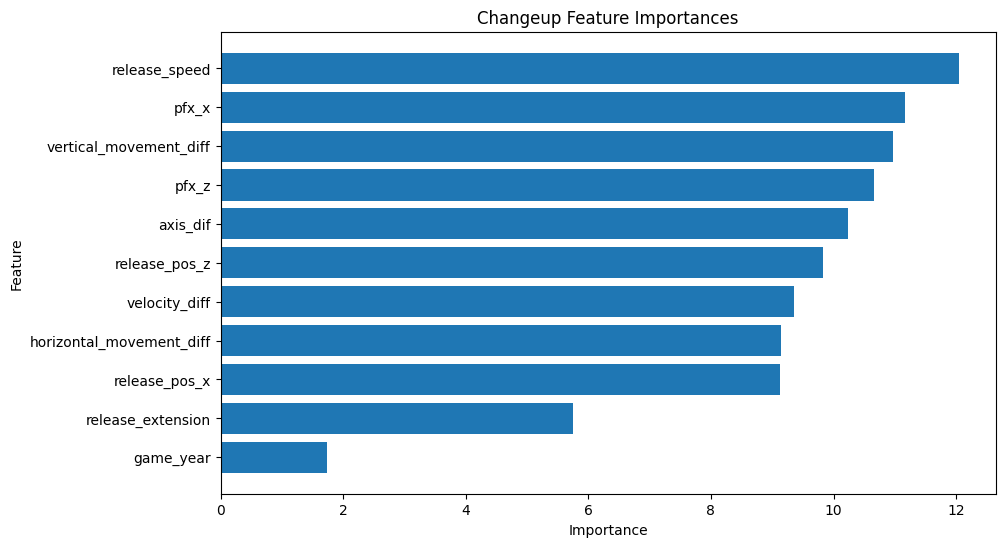

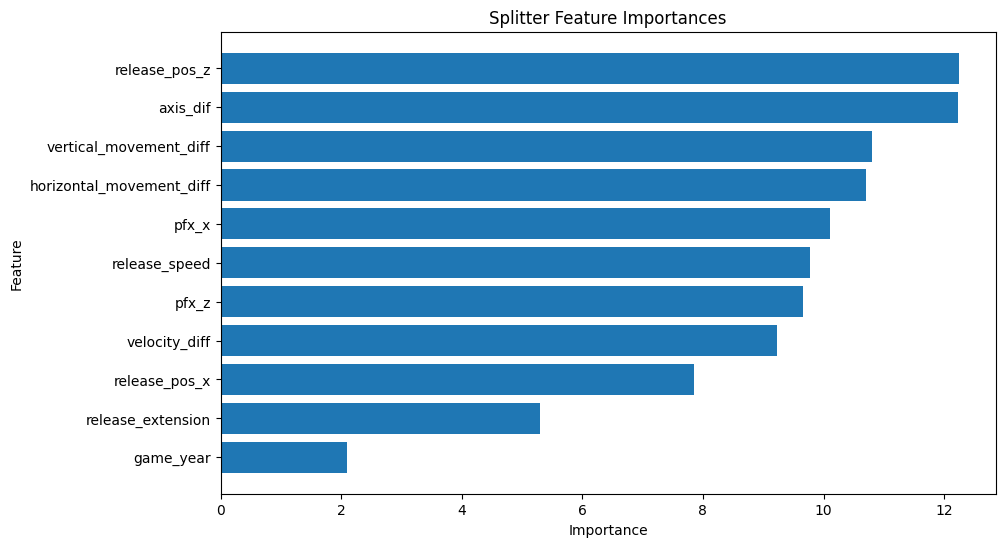

In [21]:
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importances(fastball_model, fball_features, 'Fastball Feature Importances')
plot_feature_importances(sinker_model, fball_features, 'Sinker Feature Importances')
plot_feature_importances(cutter_model, fball_features, 'Cutter Feature Importances')
plot_feature_importances(slider_model, features, 'Slider Feature Importances')
plot_feature_importances(sweeper_model, features, 'Sweeper Feature Importances')
plot_feature_importances(curveball_model, features, 'Curveball Feature Importances')
plot_feature_importances(changeup_model, features, 'Changeup Feature Importances')
plot_feature_importances(splitter_model, features, 'Splitter Feature Importances')